# Calibration 

In [48]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import transitions

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Single = RetirementClass()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Survival probabilities

In [49]:
def survival(model,age,ma,hs,scale=0.0):
    par = model.par
    if ma == 1:
        rsm = par.reg_survival_male
        dx = np.minimum(1,np.exp(rsm[0] + rsm[1]*age))
        sx = (1 - dx)*((hs==0)*(1-scale) + (hs==1)*(1+scale))
    elif ma == 0:
        rsf = par.reg_survival_female
        dx = np.minimum(1,np.exp(rsf[0] + rsf[1]*age))
        sx = (1 - dx)*((hs==0)*(1-scale) + (hs==1)*(1+scale))        
    return np.minimum(1,sx)

def middellevetid(model,age,ma,hs,scale=0.0):
    sx = survival(model,age,ma,hs,scale)
    lx = np.zeros(len(ages))
    lx[0] = 100000
    Lx = np.zeros(len(ages))
        
    for ag in range(len(ages)):
        if ag > 0:
            lx[ag] = lx[ag-1]*sx[ag-1]
            Lx[ag-1] = np.mean((lx[ag-1],lx[ag]))
            
    Tx = np.sum(Lx,axis=0)
    return Tx/lx[0]

In [50]:
ages = np.arange(57,111)
x = np.linspace(0.1,0.5,100)
diff = np.zeros((2,len(x)))
for i in range(len(x)):
    for ma in [0,1]:
        diff[ma,i] = middellevetid(Single,ages,ma,1,scale=x[i]/100) - middellevetid(Single,ages,ma,0,scale=x[i]/100)

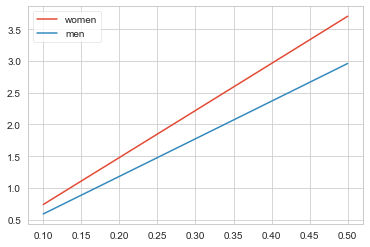

In [53]:
plt.plot(x,diff[0], label='women')
plt.plot(x,diff[1], label='men')
plt.legend()

In [5]:
scale = 0.4/100
women_ls = round(middellevetid(Single,ages,0,0,scale=scale),2)
women_base = round(middellevetid(Single,ages,0,0,scale=0.0),2)
women_hs = round(middellevetid(Single,ages,0,1,scale=scale),2)
men_ls = round(middellevetid(Single,ages,1,0,scale=scale),2)
men_base = round(middellevetid(Single,ages,1,0,scale=0.0),2)
men_hs = round(middellevetid(Single,ages,1,1,scale=scale),2)

In [8]:
data = [(women_hs, men_hs), (women_base, men_base), (women_ls, men_ls), (women_hs-women_ls, (men_hs-men_ls))]

In [14]:
pd.DataFrame(data, columns=['Women', 'Men'], index=['High skilled', 'Baseline', 'Low skilled', 'High skilled - Low skilled'])+57

,Women,Men
High skilled,83.92,80.59
Baseline,82.38,79.36
Low skilled,80.96,78.22
High skilled - Low skilled,59.96,59.37


Sample means

In [15]:
Names = [('Couples', 'Men'), ('Couples', 'Women'), ('Singles', 'Men'), ('Singles', 'Women')]
Vars = ('Net wealth', 'Pension wealth', 'Total wealth', 'Share', 'High skilled', 'Children')
NetWealth = (4790, 4790, 1899, 1856)
PensionWealth = (1236, 728, 682, 744)
TotalWealth = np.array(NetWealth) + np.array(PensionWealth)
Share = np.array(PensionWealth)/TotalWealth
Age = (61.176, 60.114, 60.625, 60.886)
HighSkilled = (0.242, 0.220, 0.196, 0.273)
Children = (0.938, 0.938, 0.558, 0.797)
data = np.vstack((NetWealth, PensionWealth, TotalWealth, Share, HighSkilled, Children))
means = pd.DataFrame(data, columns = pd.MultiIndex.from_tuples(Names), index = Vars)
means

Couples                   Singles             
                        Men        Women          Men        Women
Net wealth      4790.000000  4790.000000  1899.000000  1856.000000
Pension wealth  1236.000000   728.000000   682.000000   744.000000
Total wealth    6026.000000  5518.000000  2581.000000  2600.000000
Share              0.205111     0.131932     0.264239     0.286154
High skilled       0.242000     0.220000     0.196000     0.273000
Children           0.938000     0.938000     0.558000     0.797000

In [29]:
p = np.array(PensionWealth)*1000/100000

In [33]:
p

array([12.36,  7.28,  6.82,  7.44])

In [43]:
sh = 0.242
g = 0.5

In [44]:
pl = xl(g,sh)*p[0]
ph = xh(g,sh)*p[0]

In [45]:
pl

11.025869759143621

In [46]:
ph

16.538804638715433

In [47]:
pl*(1-sh)+ph*sh-p[0]

0.0

In [34]:
def xl(g,sh):
    return 1/(1+sh*g)

def xh(g,sh):
    return (1+g)/(1+sh*g)

In [32]:
Single.par.pension_male

array([ 6.52582, 12.34028])

Regressions

In [4]:
Names = [('Couples', 'Men'), ('Couples', 'Women'), ('Singles', 'Men'), ('Singles', 'Women')]
Vars = ('g', 'Age', 'Age2', 'High skilled', 'Child', 'Log wealth', 'Log wealth2', 'Log wealth3', 'Constant')
g = (0.262, 0.318, 0.230, 0.248)
Age = (0.072, 0.039, 0.216, 0.098)
Age2 = (-0.068, -0.037, -0.187, -0.091)
HighSkilled = (0.069, 0.131, 0.142, 0.185)
Child = (0.026, -0.024, 0.019, -0.032)
LogWealth = (8.864, 4.290, 12.057, 10.062)
LogWealth2 = (-0.655, -0.327, -0.920, -0.732)
LogWealth3 = (0.016, 0.008, 0.023, 0.018)
Constant = (-41.161, -19.000, -57.670, -47.565)
data = np.vstack((g, Age, Age2, HighSkilled, Child, LogWealth, LogWealth2, LogWealth3, Constant))
reg = pd.DataFrame(data, columns = pd.MultiIndex.from_tuples(Names), index=Vars)
reg

Couples         Singles        
                 Men   Women     Men   Women
g              0.262   0.318   0.230   0.248
Age            0.072   0.039   0.216   0.098
Age2          -0.068  -0.037  -0.187  -0.091
High skilled   0.069   0.131   0.142   0.185
Child          0.026  -0.024   0.019  -0.032
Log wealth     8.864   4.290  12.057  10.062
Log wealth2   -0.655  -0.327  -0.920  -0.732
Log wealth3    0.016   0.008   0.023   0.018
Constant     -41.161 -19.000 -57.670 -47.565

Predict pension wealth

In [5]:
def xl(g,sh):
    return 1/(1+sh*g)

def xh(g,sh):
    return (1+g)/(1+sh*g)

def share(means,reg,hs):
    return means.loc['Share'] + hs*reg.loc['High skilled']

def total_wealth(means,reg,hs):
    if hs == 1:
        return xh(reg.loc['g'], means.loc['High skilled'])*means.loc['Total wealth']
    elif hs == 0:
        return xl(reg.loc['g'], means.loc['High skilled'])*means.loc['Total wealth']

In [8]:
Names = [('High skilled', 'Couples', 'Men'), ('High skilled', 'Couples', 'Women'),
         ('High skilled', 'Singles', 'Men'), ('High skilled', 'Singles', 'Women'),
         ('Low skilled', 'Couples', 'Men'), ('Low skilled', 'Couples', 'Women'),
         ('Low skilled', 'Singles', 'Men'), ('Low skilled', 'Singles', 'Women')]
Vars = ('Pension wealth', 'Net wealth', 'Total wealth', 'Share')

In [9]:
Names = [('Couples', 'Men'), ('Couples', 'Women'), ('Singles', 'Men'), ('Singles', 'Women')]
PredH = pd.DataFrame(np.nan*np.zeros((4,4)), columns = pd.MultiIndex.from_tuples(Names), index=Vars)
PredL = pd.DataFrame(np.nan*np.zeros((4,4)), columns = pd.MultiIndex.from_tuples(Names), index=Vars)

In [10]:
PredH.loc['Share'] = share(means,reg,1)
PredL.loc['Share'] = share(means,reg,0)
PredH.loc['Total wealth'] = total_wealth(means,reg,1)
PredL.loc['Total wealth'] = total_wealth(means,reg,0)
PredH.loc['Pension wealth'] = PredH.loc['Share']*PredH.loc['Total wealth']
PredL.loc['Pension wealth'] = PredL.loc['Share']*PredL.loc['Total wealth']
PredH.loc['Net wealth'] = PredH.loc['Total wealth']-PredH.loc['Pension wealth']
PredL.loc['Net wealth'] = PredL.loc['Total wealth']-PredL.loc['Pension wealth']

In [11]:
np.round(PredH.loc['Pension wealth']*1000)

Couples  Men      1960275.0
         Women    1787198.0
Singles  Men      1234028.0
         Women    1431858.0
Name: Pension wealth, dtype: float64

In [12]:
np.round(PredL.loc['Pension wealth']*1000)

Couples  Men      1162305.0
         Women     680399.0
Singles  Men       652582.0
         Women     696822.0
Name: Pension wealth, dtype: float64

In [13]:
np.allclose(PredH.loc['Total wealth']*means.loc['High skilled'] + PredL.loc['Total wealth']*(1-means.loc['High skilled']),
            means.loc['Total wealth'])

True

In [14]:
np.allclose(PredH.loc['Net wealth']*means.loc['High skilled'] + PredL.loc['Net wealth']*(1-means.loc['High skilled']),
            means.loc['Net wealth'])

False

In [15]:
PredH.loc['Net wealth']*means.loc['High skilled'] + PredL.loc['Net wealth']*(1-means.loc['High skilled'])

Couples  Men      4670.586164
         Women    4594.104915
Singles  Men      1814.454987
         Women    1702.513056
dtype: float64

In [16]:
means.loc['Net wealth']

Couples  Men      4790.0
         Women    4790.0
Singles  Men      1899.0
         Women    1856.0
Name: Net wealth, dtype: float64